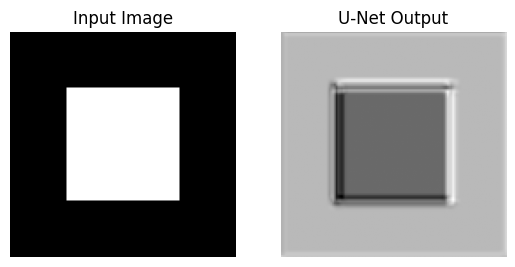

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

#Dummy Image
# 128x128 mit zwei Bereiche
image = np.zeros((128, 128), dtype=np.float32)
image[32:96, 32:96] = 1.0  # quadratisches Objekt

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

#Einfacher Mini U-Net
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(1, 8, 3, padding=1)
        self.enc2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec1 = nn.Conv2d(16, 8, 3, padding=1)
        self.out = nn.Conv2d(8, 1, 1)

    def forward(self, x):
        x1 = F.relu(self.enc1(x))
        x2 = F.relu(self.enc2(self.pool(x1)))
        x3 = F.relu(self.dec1(self.up(x2)))
        x4 = torch.sigmoid(self.out(x3))
        return x4

# Modell und Input vorbereiten
model = MiniUNet()
model.eval()  # eval mode, keine Gradienten nötig

input_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)  # [B, C, H, W]
with torch.no_grad():
    output = model(input_tensor).squeeze().numpy()

#Ergebnis anzeigen
plt.subplot(1, 2, 2)
plt.title("U-Net Output")
plt.imshow(output, cmap='gray')
plt.axis('off')

plt.show()


CNN

Epoch 1/20, Train Loss: 1.8309, Val Loss: 1.6289
Epoch 2/20, Train Loss: 1.5436, Val Loss: 1.5691
Epoch 3/20, Train Loss: 1.4160, Val Loss: 1.4993
Epoch 4/20, Train Loss: 1.3201, Val Loss: 1.3084
Epoch 5/20, Train Loss: 1.2511, Val Loss: 1.2851
Epoch 6/20, Train Loss: 1.1874, Val Loss: 1.2366
Epoch 7/20, Train Loss: 1.1527, Val Loss: 1.2051
Epoch 8/20, Train Loss: 1.1213, Val Loss: 1.2287
Epoch 9/20, Train Loss: 1.0808, Val Loss: 1.1735
Epoch 10/20, Train Loss: 1.0530, Val Loss: 1.2109
Epoch 11/20, Train Loss: 1.0325, Val Loss: 1.0983
Epoch 12/20, Train Loss: 1.0092, Val Loss: 1.1235
Epoch 13/20, Train Loss: 0.9782, Val Loss: 1.1850
Epoch 14/20, Train Loss: 0.9639, Val Loss: 1.1515
Epoch 15/20, Train Loss: 0.9478, Val Loss: 1.1200
Epoch 16/20, Train Loss: 0.9152, Val Loss: 1.1353
Epoch 17/20, Train Loss: 0.8947, Val Loss: 1.0489
Epoch 18/20, Train Loss: 0.8710, Val Loss: 1.0560
Epoch 19/20, Train Loss: 0.8542, Val Loss: 1.0512
Epoch 20/20, Train Loss: 0.8611, Val Loss: 1.1100


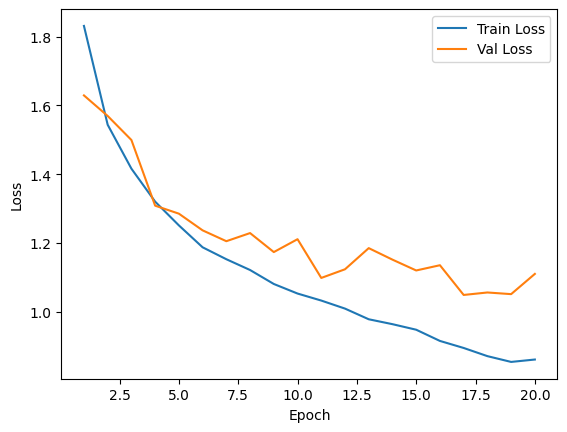

Validation Accuracy: 61.70%


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt

# für Notebook: Plots inline
%matplotlib inline

# ----------------------------
# 1. Daten vorbereiten (Mini-Subset + Augmentation)
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
subset_indices = list(range(10000))  # kleines Subset für schnelle Tests
subset = Subset(dataset, subset_indices)

train_dataset, val_dataset = random_split(subset, [8000,2000])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ----------------------------
# 2. Mini-CNN mit BatchNorm + Dropout
# ----------------------------
class MiniCNN(nn.Module):
    def __init__(self):
        super(MiniCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*4*4, 64)
        self.dropout = nn.Dropout(0.2)  # Dropout vor FC Layer
        self.fc2 = nn.Linear(64, 10)  # CIFAR10: 10 Klassen

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 64*4*4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ----------------------------
# 3. Training Setup
# ----------------------------
device = torch.device("cpu")
model = MiniCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # L2 Regularization   

num_epochs = 20
train_losses, val_losses = [], []

# ----------------------------
# 4. Training Loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.to(device))
            loss = criterion(outputs, labels.to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# ----------------------------
# 5. Loss Plot
# ----------------------------
plt.plot(range(1,num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1,num_epochs+1), val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



# Validation
model.eval()
val_loss = 0.0
correct_total = 0
total_samples = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        val_loss += loss.item()
        
        # Accuracy berechnen
        preds = torch.argmax(outputs, dim=1)
        correct_total += (preds == labels.to(device)).sum().item()
        total_samples += labels.size(0)

val_accuracy = correct_total / total_samples
print(f"Validation Accuracy: {val_accuracy:.2%}")
